# bistro (bayesian inference simplification for regression of treatment on outcome)

### Version 1.0 (Python versions > 3.8)
D. M. Burt


### TODO
1. Put ```plot_effects``` into class body.  
2. Genericize ```plot_effects```:  
    a. add a model type to specify difference-in-difference  
    b. pass TREAT and POST as variables (rather than leaving them hardcoded as TREAT and POST)  
3. Split data passed to fit into ```data_treat``` and ```data_control```.
    a. Implement getters and setters for ```self.data_treat``` and ```self.data_control```.
    b. ```self.data_control``` will be set/reset by matching function.
4. Add propensity score estimation and matching  
    a. nearest neighbor, caliper  
5. 

In [1]:
# activate a python 3.11 virtual environment: source python3.11/bin/activate
# pip install pymc==4.4 (at the moment, v5 is not working)
# remove aesara (pymc started using pytensor, and recently there are ambiguity warnings coming from having both installed)
# pip install bambi patsy seaborn graphviz

# data libraries
import pandas as pd
import numpy as np
import patsy as pt
import xarray as xr

# stats libraries
#import pymc3 as pm 
import pymc as pm
import bambi as bmb
import arviz as az

# control group matching libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# viz libraries
# Note: graphviz will require additional binaries to be installed
import graphviz
import seaborn as sns
from tabulate import tabulate
from matplotlib import pyplot as plt
from matplotlib import rc

'''
# Linux font setup
rc('font',**{'family':'sans-serif',
             'sans-serif':['Helvetica', 'Roboto-Regular', 'Roboto', 'roboto', 'roboto-regular'],
             'size':10
            }
  )
'''


# Windows font setup
rc('font',**{'family':'sans-serif',
             'sans-serif':['Aptos', 'Arial'],
             'size':10
            }
  )


import watermark

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
__version__ = '1.0.20221230'

class BModel:
    
    def _convert_dataset(self, dataset, dataset_name):
        '''
        _convert_dataset
        Test if dataset is of type xarray Dataset.  If the dataset is pandas, convert to xarray Dataset.  
        If the dataset is not of a supported type, throw error.
        '''
        accepted_dataset_types = {'pandas DataFrame': pd.core.frame.DataFrame, 
                                  'xarray Dataset': xr.core.dataset.Dataset
                                 }
        
        # Pass xarray Dataset
        if isinstance(dataset, xr.core.dataset.Dataset):
            return dataset
        
        # Convert pandas
        if isinstance(dataset, pd.core.frame.DataFrame):
            dataset_temp = dataset.copy(deep=True)
            idx = pd.Index.rename(dataset_temp.index, name='observation')
            dataset_temp.index = idx
            return xr.Dataset.from_dataframe(dataset_temp)
        
        # Fall-through case: throw error
        raise Exception(f'The datasets passed must be of one of the following types: {accepted_dataset_types.keys()}.\n \
                          The supplied dataset {dataset_name} is of type {type(dataset)}.')
            
    
    def __init__(self, data_treat=None, data_control=None, treat_var=None):
        '''
        __init__
        -------------
        data_treat:   required.  Must be of type pandas DataFrame or xarray.
        data_control: required.  Must be of type pandas DataFrame or xarray.
        treat_var:    required.  If this variable does not exist in data_treat and/or data_control, it will
                                 be added to the combined dataset returned by this method.
        
        TODO: CURRENTLY DESIGNED FOR PANDAS.  NEED TO REFACTOR TO SUPPORT XARRAY AND NUMPY
        
        '''
        
        if treat_var is None:
            raise Exception(f'The treat_var parameter must be specified.')
            
        self.data_treat   = self._convert_dataset(data_treat, 'data_treat')
        self.data_treat.attrs['bistro_version'] = __version__
        self.data_treat.attrs['Treat group variable'] = treat_var
        self.data_control = self._convert_dataset(data_control, 'data_control')
        self.data_control.attrs['bistro_version'] = __version__
        self.data_control.attrs['Treat group variable'] = treat_var
        
            
        # Check to see if datasets have the same columns (not counting the treat indicator variable in either)
        data_treat_vars   = sorted(list(self.data_treat.keys()))
        data_treat_vars.remove(treat_var)
        
        data_control_vars   = sorted(list(self.data_control.keys()))
        data_control_vars.remove(treat_var)
        
        if np.sum(data_treat_vars != data_control_vars) > 0:
            raise Exception(f'data_treat and data_control have different variables (or at least differently-named).')
            
        ## HERE!  Need to merge treat and control Datasets
        # Start combined dataset for internal instance storage
        self.data_combined = data_treat.copy(deep=True)  # do not want to merely create reference to original
        temp_data_control  = data_control.copy(deep=True)
                        
        if treat_var not in self.data_combined.columns:
            self.data_combined[treat_var] = int(1)
            
        if treat_var not in data_control.columns:            
            temp_data_control[treat_var] = int(1)
            
        self.data_combined = pd.concat([self.data_combined, temp_data_control], axis=0)
        


        
    def _fit_did(self, reg_formula=None):
        '''
        _fit_did
        Private function to fit difference-in-difference model.
        Intended to be called from public fit() function with "did" type specification.
        
        The reg_formula (patsy-style, see below) must refer to variables that exist in both data_control and
        data_treat sets, with the exception of treat_var.  If the specified treat_var is not present in either
        dataset (or both), then it will be added when data_treat and data_control are combined together.        


        ----------------
        reg_formula:  required.  Formula in patsy style to describe DiD regression.
                                 For a DiD regression, the formula is expected to have (at least) a binary TREAT
                                 variable and a binary POST variable with an interaction term, such as:
                                 "outcome ~ treat + post + treat*post".                                 
                                 More information on patsy formulas: https://patsy.readthedocs.io/en/latest/formulas.html
                                 
        
        '''
        self.reg_formula = reg_formula
        
        # Patsy stuff, if needed.  May want to remove these in the future if not used.
        self._did_y, self._did_x = pt.dmatrices(formula_like=reg_formula, data=self.data_combined)
        self._did_y = np.asarray(self._did_y).flatten()
        
        if isinstance(self.data_combined, xr.core.dataset.Dataset):
            self.fitted_model = bmb.Model(reg_formula, self.data_combined.to_dataframe()).fit()
        elif isinstance(self.data_combined, pd.core.frame.DataFrame):
            self.fitted_model = bmb.Model(reg_formula, self.data_combined).fit()
        
    def fit(self, model_type='did', reg_formula=None):
        '''
        fit
        Public function to fit regression model.

        ------------------
        model_type:  required.  Currently only supports "did" (difference-in-difference)
        reg_formula: required.  Formula in patsy style.  Specification depends on model type (more below).
        
        
        Patsy formula specifications:
        
        For a DiD regression, the formula is expected to have (at least) a binary TREAT
        variable and a binary POST variable with an interaction term, such as:
        "outcome ~ treat + post + treat*post".
        More information on patsy formulas: https://patsy.readthedocs.io/en/latest/formulas.html
                                 
          
        '''
        
        valid_model_types = ['did']
        
        if model_type is None:
            raise Exception(f'Fit requires model _type to be specified (currently supported: {valid_model_types}).')
        if model_type not in valid_model_types:
            raise Exception(f'Fit requires model _type to be one of {valid_model_types}), but {model_type} was given.')
        
        if model_type=='did':
            self._fit_did(reg_formula=reg_formula)
        
        
        
    def plot_trace(self):
        '''
        plot_trace
        Convenience function for arviz plot_trace
        '''
        az.plot_trace(self.fitted_model)
        plt.tight_layout()
        sns.despine()
        plt.show();
        
        
    
    def _plot_hdi_density(self, data=None, interval=0.89, figsize=None):
        '''
        _plot_hdi_density
        Private function to simplify a Seaborn kernel density estimate plot of data distributions
        ----------------
        data:      optional.  Defaults to posterior estimates of fitted_model
        interval:  optional.  Defaults to 0.89 (i.e., 89% HDI).  Must be between 0.01 and 0.99.
        '''

        if data is None:
            data = self.fitted_model['posterior'].to_dataframe()
            
        list_params = data.columns
        n_params = len(list_params)
        
        n_rows = np.floor(np.sqrt(n_params)).astype(int)
        n_cols = np.ceil(n_params/n_rows).astype(int)

        if (interval < 0.01 or interval > 0.99):
            raise Exception(f'interval supplied ({interval}) is invalid--this parameter must be between 0.01 and 0.99 (inclusive).')

        if figsize is None:
            figsize = (n_cols*3, n_rows*3)
            
        caption_zero = 'x=0 shown in red if it exists in the HDI.'

        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
        fig.suptitle(f'Density of Parameter Estimates ({int(interval*100):d}% HDI)')
        fig.text(0.5, 0.935, caption_zero, ha='center', size=8, color='firebrick')

        # turn off axes by default (we will turn them back on during the plotting loop)
#         for cur_ax in ax:
#             cur_ax.set_axis_off()
        
        plot_index = 0
        
        for cur_row in range(n_rows):
            for cur_col in range(n_cols):
        
                ax[cur_row][cur_col].set_axis_off()
            
                if plot_index < n_params:
                    
                    ax[cur_row][cur_col].set_axis_on()

                    # data setup with interpolation--data for plot is sampled from original data to reduce compute overhead
                    # and interpolation is added for KDE smoothing.
                    #data_sample = np.random.choice(self.data.iloc[:,p], replace=False, size=min([len(self.data.iloc[:,p]), 1000]))
                    data_sample = data.iloc[:,plot_index].sample(min([len(data.iloc[:,plot_index]), 1000]), replace=False)
                    #data_sample.sort()


                    # highest-density interval (HDI) calculation, using the quantile range specified by the ::interval parameter
                    # Note: this is actually an equal-tailed interval (ETI), as opposed to a true HDI, for simplicity in calculation
                    #       I'm assuming the parameter estimates will be reasonably symmetrical (not necessarily true for posterior),
                    #       hence the reason I'm cheating a little here.
                    hdi_lo = np.quantile(data_sample, ((1-interval)/2))
                    hdi_hi = np.quantile(data_sample, (1-(1-interval)/2))
                    hdi_median = np.quantile(data_sample, 0.5)
                    hdi_range = hdi_hi - hdi_lo        


                    # plot
                    g = sns.kdeplot(data_sample, clip=(hdi_lo, hdi_hi), color='#333', fill='#777', alpha=0.6, ax=ax[cur_row][cur_col])
                    g.set_title(f'{list_params[plot_index]}', size=10)
                    g.set_xlim(hdi_lo-0.2*hdi_range, hdi_hi+0.2*hdi_range)
                    g.xaxis.set_tick_params(labelsize=8)
                    g.xaxis.set_label_text(' ')
                    g.yaxis.set_tick_params(labelsize=8)
                    if cur_col != 0:
                        g.yaxis.set_label_text(' ')

                    # plot x=0, if it is within the HDI (ETI)
                    if hdi_lo < 0 and hdi_hi > 0:
                        g.axvline(0, color='firebrick', alpha=0.2, linestyle='--')
                    g.axvline(hdi_median, color='#fff', linestyle=':')
                    g.annotate(xy=[hdi_median + hdi_range*0.02, g.get_ylim()[1]*0.02], text=f'median:\n{np.round(hdi_median,3)}', color='w', size=8)
                    g.axvline(hdi_lo, color='#777', linestyle=':')
                    g.annotate(xy=[hdi_lo + hdi_range*0.02, g.get_ylim()[1]*.9], text=f'{(1-interval)/2*100:.1f}%:\n{np.round(hdi_lo,3)}', color='#222', size=8)
                    g.axvline(hdi_hi, color='#777', linestyle=':')
                    g.annotate(xy=[hdi_hi + hdi_range*0.02, g.get_ylim()[1]*.9], text=f'{(1-(1-interval)/2)*100:.1f}%:\n{np.round(hdi_hi,3)}', color='#222',size=8)

                plot_index += 1
            
        plt.tight_layout()
        sns.despine()
        plt.show();
        
    
    def label_line (self, line, label, x_pos, ax, label_fontsize, y_pad=None, color=None, 
                    angle_deg=None, split_point=0, above_line=True):
        '''
        label_line
        -----------
        line:
        label:
        x_pos:
        ax:
        y_pad:      optional.  Defaults with auto-scaling
        color:      optional.  Defaults to line color
        angle_deg:  DEV FN TO BE DEPRECATED AFTER ROTATION FEATURE VERIFIED
        split_point:
        above_line: Boolean value, defaulted to True, that specifies if label should appear above the line.
                    A value of False will put the label below the line.
        '''


        line_xydata = line.get_xydata()
        line_xydata = line_xydata[line_xydata[:,0]>=split_point]
        y_lim = ax.get_ylim()
        intercept = line_xydata[0][1]
        rise = line_xydata[-1][1] - intercept
        run = line_xydata[-1][0] - split_point
        y_pos = intercept + x_pos*(rise*run)


        if angle_deg is None:
            angle_deg = np.degrees(np.arctan2(rise,run))


        if y_pad is None:
            y_pad = 0.02 * (y_lim[1]-y_lim[0])
            
        if color is None:
            color = line.get_color()


        ax.text(x=x_pos, 
                y=y_pos + (1 if above_line else -1.5) * y_pad, 
                s=label,
                size=label_fontsize,
                rotation=(angle_deg), 
                rotation_mode='anchor',            
                transform_rotates_text=True,
                color=color
               )




    def plot_effects(self,
                     model, 
                     line_type='single', 
                     show_intervals=True, 
                     split_point=0,
                     n_lines=10,
                     figsize=(9,3),
                     hdi=0.89,
                     plot_interval=True,
                     show_did=False,
                     title_fontsize=12,
                     suptitle_fontsize=14,
                     tick_fontsize=8,
                     label_fontsize=10,
                     control_color='#333333',
                     treat_factual_color='#1295D8',
                     treat_counterfactual_color='#005581',
                     y_label='Y',
                     y_pad = (0.02, 0.02, 0.02),
                     labels_above_line = (True, True, True)
                    ):
        '''
        plot_effects
        -----------
        Plot difference-in-difference results as regression lines


        TODO: 1) Currently requires that ind. variables are named TREAT and POST.  
                 May require a function in the class to extract variables (and exclude outcome var).


        model:
        line_type:
        show_intervals:
        split_point:    optional.  Split factual and counterfactual lines along x at this point (between 0 and 1)
        n_lines:        optional.  Used in multi mode, and specifies the number of sample lines to plot from posterior.
                                    Defaults to 10.
        figsize:        optional.  Tuple specifiying size of plot, in inches (width, height).                                
        hdi:            optional.  Highest-density interval, used to plot credible interval in single mode.  Must be
                                   greater than 0 and less than 1.
        plot_interval   optional.  If True, plot the highest-density interval around the lines.  Only available in
                                   single mode.  If specified in multi mode, this parameter will be ignored.
        show_did        optional.  If True, plot the difference-in-difference line to show the meaningful effect.
        title_fontsize
        tick_fontsize
        label_fontsize
        control_color
        treat_factual_color
        treat_counterfactual_color
        y_label
        y_pad                      Tuple of floats that control padding to apply to y-position.
                                   The positions in the tuple correspond to:
                                   (treat_factual, treat_counterfactual, control)
                                   
        labels_above_line          Tuple of booleans that control whether labels appear above (True) or below (False)
                                   their respective lines.  The positions in the tuple correspond to:
                                   (treat_factual, treat_counterfactual, control)
        '''




        # Validations
        if (hdi <= 0) or (hdi >= 1):
            raise Exception(f"plot_effects() hdi parameter must be between 0 and 1 (exclusive), but {hdi} was specified.")


        # Establish dataset
        temp_intercept = self.fitted_model['posterior']['Intercept'].to_numpy().ravel()
        temp_treat = self.fitted_model['posterior']['TREAT'].to_numpy().ravel()
        temp_post = self.fitted_model['posterior']['POST'].to_numpy().ravel()
        temp_interact = self.fitted_model['posterior']['TREAT:POST'].to_numpy().ravel()


        interval = (1-hdi)
        interval_point_lo = interval/2
        interval_point_hi = 1-interval/2


        # Reduce dataset for plotting, based on line_type mode
        if line_type == 'single':
            plt_intercept = np.asarray([np.quantile(temp_intercept, 0.5)])
            plt_treat = np.asarray([np.quantile(temp_treat, 0.5)])
            plt_post = np.asarray([np.quantile(temp_post, 0.5)])
            plt_interact = np.asarray([np.quantile(temp_interact, 0.5)])
            n_lines = 1
            line_alpha = 1




            hdi_lo_intercept = np.asarray([np.quantile(temp_intercept, interval_point_lo)])
            hdi_hi_intercept = np.asarray([np.quantile(temp_intercept, interval_point_hi)])
            hdi_lo_treat = np.asarray([np.quantile(temp_treat, interval_point_lo)])
            hdi_hi_treat = np.asarray([np.quantile(temp_treat, interval_point_hi)])
            hdi_lo_post = np.asarray([np.quantile(temp_post, interval_point_lo)])
            hdi_hi_post = np.asarray([np.quantile(temp_post, interval_point_hi)])
            hdi_lo_interact = np.asarray([np.quantile(temp_interact, interval_point_lo)])
            hdi_hi_interact = np.asarray([np.quantile(temp_interact, interval_point_hi)])


        elif line_type == 'multi':
            plt_intercept = temp_intercept
            plt_treat = temp_treat
            plt_post = temp_post
            plt_interact = temp_interact
            line_alpha = 0.1
            plot_interval = None
        else:
            raise Exception(f"plot_effects() line_type parameter takes the values 'single' or 'multi'. {line_type} was specified.")


        #split_point=0 if diverge_midway==True else 0.5


        fig, ax = plt.subplots(1,2, figsize=figsize)


        ylim_padding = 0.1 # percent of slope/effect


        # Establish y-axis limits, using all pertinent data for plotting
        ylim_lo = np.min([0, 
                          np.min(plt_intercept) * (1+ylim_padding), 
                          (np.min(plt_intercept + plt_treat)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_post)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_treat + plt_post)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_treat + plt_post + plt_interact)) * (1+ylim_padding)
                         ]
                        )


        ylim_hi = np.max([np.min(plt_intercept) * (1+ylim_padding), 
                          (np.min(plt_intercept + plt_treat)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_post)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_treat + plt_post)) * (1+ylim_padding),
                          (np.min(plt_intercept + plt_treat + plt_post + plt_interact)) * (1+ylim_padding)
                         ]
                        )


        ax[0].set_ylim(np.min([0,ylim_lo]), ylim_hi)


        # PLOTTING SECTION
        for i in range(n_lines):


            # Set up data
            x = np.asarray([0, split_point, 1])
            treat_y_counterfactual = np.asarray([plt_intercept[i] + plt_treat[i], 
                                                 plt_intercept[i] + plt_treat[i] + split_point*plt_post[i],
                                                 plt_intercept[i] + plt_treat[i] + plt_post[i]
                                                ])
            treat_y_factual = np.asarray([plt_intercept[i] + plt_treat[i], 
                                          plt_intercept[i] + plt_treat[i] + split_point*plt_post[i] + 0*plt_interact[i],
                                          plt_intercept[i] + plt_treat[i] + plt_post[i] + plt_interact[i]
                                         ])
            control_y = np.asarray([plt_intercept[i], 
                                    plt_intercept[i] + split_point*plt_post[i],
                                    plt_intercept[i] + plt_post[i]
                                   ])
            did_y = np.asarray([plt_intercept[i] + plt_treat[i] + plt_post[i] + plt_interact[i],
                                plt_intercept[i] + plt_treat[i] + plt_post[i]
                               ])
            did_direction = -1 if did_y[0] < did_y[1] else 1


            # Plot lines
            line_treat_counterfactual, = ax[0].plot(x, 
                                                 treat_y_counterfactual, 
                                                 color=treat_counterfactual_color, 
                                                 linestyle='--', 
                                                 alpha=line_alpha
                                                )
            line_treat_factual, = ax[0].plot(x, 
                                          treat_y_factual, 
                                          color=treat_factual_color, 
                                          alpha=line_alpha
                                         )
            line_control, = ax[0].plot(x, 
                                    control_y, 
                                    color=control_color, 
                                    alpha=line_alpha
                                   )
            if show_did:
                if i==0:
                    #ax.vlines(1.01, ymin=np.min(did_y), ymax=np.max(did_y), color='#FDB515')  #c4820e
                    ax[0].arrow(1.02, did_y[1], dx=0, 
                             dy=did_direction*np.abs((did_y[0] - did_y[1])), length_includes_head=True,
                             head_width=0.01, head_length=0.2,
                             color='#FDB515')
                    ax[0].annotate(f'DiD:\n{did_direction*np.abs((did_y[0] - did_y[1])):.3f}', 
                                xy=[1.03, np.min(did_y)], 
                                color='#c4820e', size=label_fontsize
                               )




            # Control axis size and tick labels.  If a non-zero split_point is specified, include "intervention"
            ax[0].set_ylabel(y_label)
            if split_point!=0:
                ax[0].set_xticks([0, split_point, 1], labels=['PRE', 'Intervention', 'POST'], fontsize=tick_fontsize)
                ax[0].axes.yaxis.set_tick_params(labelsize=tick_fontsize)
                ax[0].axvline(x=split_point, linestyle=':', color='#333', alpha=0.2)
            else:
                ax[0].set_xticks([0,1], labels=['PRE','POST'], fontsize=tick_fontsize)
                ax[0].axes.yaxis.set_tick_params(labelsize=tick_fontsize)


            # Calculate and plot interval lines
            if plot_interval is not None and plot_interval==True:


                ### treat factual
                treat_y_factual_interval_hi = np.asarray([hdi_hi_intercept + hdi_hi_treat, 
                                                          hdi_hi_intercept + hdi_hi_treat + split_point*hdi_hi_post + 0*hdi_hi_interact,
                                                          hdi_hi_intercept + hdi_hi_treat + hdi_hi_post + hdi_hi_interact
                                                         ])
                treat_y_factual_interval_lo = np.asarray([hdi_lo_intercept + hdi_lo_treat, 
                                                          hdi_lo_intercept + hdi_lo_treat + split_point*hdi_lo_post + 0*hdi_lo_interact,
                                                          hdi_lo_intercept + hdi_lo_treat + hdi_lo_post + hdi_lo_interact
                                                         ])
                line_treat_factual_interval_hi = ax[0].plot(x,
                                                         treat_y_factual_interval_hi,
                                                         color=treat_factual_color,
                                                         alpha=0.05
                                                        )
                line_treat_factual_interval_lo = ax[0].plot(x,
                                                         treat_y_factual_interval_lo,
                                                         color=treat_factual_color,
                                                         alpha=0.05
                                                        )


                ax[0].fill_between(x, np.ravel(treat_y_factual_interval_hi), 
                                np.ravel(treat_y_factual_interval_lo), 
                                color=treat_factual_color, alpha=0.05)


                ### treat counterfactual
                treat_y_counterfactual_interval_hi = np.asarray([hdi_hi_intercept + hdi_hi_treat,
                                                                 hdi_hi_intercept + hdi_hi_treat + split_point*hdi_hi_post,
                                                                 hdi_hi_intercept + hdi_hi_treat + hdi_hi_post
                                                                ])
                treat_y_counterfactual_interval_lo = np.asarray([hdi_lo_intercept + hdi_lo_treat,
                                                                 hdi_lo_intercept + hdi_lo_treat + split_point*hdi_lo_post,
                                                                 hdi_lo_intercept + hdi_lo_treat + hdi_lo_post
                                                                ])
                line_treat_counterfactual_interval_hi = ax[0].plot(x,
                                                                treat_y_counterfactual_interval_hi,
                                                                color=treat_counterfactual_color,
                                                                alpha=0.05
                                                               )
                line_treat_counterfactual_interval_lo = ax[0].plot(x,
                                                                treat_y_counterfactual_interval_lo,
                                                                color=treat_counterfactual_color,
                                                                alpha=0.05
                                                               )


                ax[0].fill_between(x, np.ravel(treat_y_counterfactual_interval_hi), 
                                np.ravel(treat_y_counterfactual_interval_lo), 
                                color=treat_counterfactual_color, alpha=0.05)


                ### control
                control_y_interval_hi = np.asarray([hdi_hi_intercept, 
                                                    hdi_hi_intercept + split_point*hdi_hi_post,
                                                    hdi_hi_intercept + hdi_hi_post
                                                   ])
                control_y_interval_lo = np.asarray([hdi_lo_intercept, 
                                                    hdi_lo_intercept + split_point*hdi_lo_post,
                                                    hdi_lo_intercept + hdi_lo_post
                                                   ])
                line_control_interval_hi = ax[0].plot(x,
                                                   control_y_interval_hi,
                                                   color=control_color,
                                                   alpha=0.1
                                                  )
                line_control_interval_lo = ax[0].plot(x,
                                                   control_y_interval_lo,
                                                   color=control_color,
                                                   alpha=0.1
                                                  )


                ax[0].fill_between(x, np.ravel(control_y_interval_hi), 
                                np.ravel(control_y_interval_lo), 
                                color=control_color, alpha=0.1)
                
                
                y_lo = np.min([control_y_interval_lo, 
                               treat_y_factual_interval_lo, 
                               treat_y_counterfactual_interval_lo
                              ])*1.1
                if y_lo > 0: y_lo=0
                ax[0].set_ylim(y_lo,
                               np.max([control_y_interval_hi, 
                                       treat_y_factual_interval_hi, 
                                       treat_y_counterfactual_interval_hi
                                      ]) * 1.1
                              )
                                      


            # label the lines.  In multi mode, only label once (on the first pass)
            if i==0:
                self.label_line(line_treat_counterfactual,
                                'Treat counterfactual', 
                                x_pos=0.7, 
                                ax=ax[0], 
                                split_point=split_point, 
                                label_fontsize=label_fontsize,
                                y_pad=y_pad[1],
                                above_line = labels_above_line[1]
                               )
                self.label_line(line_treat_factual, 
                                'Treat factual', 
                                x_pos=0.7, 
                                ax=ax[0], 
                                split_point=split_point,
                                label_fontsize=label_fontsize,
                                y_pad=y_pad[0],
                                above_line = labels_above_line[0]
                               )
                self.label_line(line_control, 
                                'Control actual', 
                                x_pos=0, 
                                ax=ax[0], 
                                split_point=0,
                                label_fontsize=label_fontsize,
                                y_pad=y_pad[2],
                                above_line = labels_above_line[2]
                               )








        # Right-hand side plot: 


        did_hdi_lo = np.quantile(temp_interact, interval_point_lo)
        did_hdi_hi = np.quantile(temp_interact, interval_point_hi)
        did_hdi_median = np.quantile(temp_interact, 0.5)
        did_hdi_range = did_hdi_hi - did_hdi_lo        


        # colors '#FDB515'  ''#C4820E'
        g = sns.kdeplot(temp_interact, color='#FDB515', fill='#FDB515', alpha=0.1, ax=ax[1])
        g = sns.kdeplot(temp_interact, clip=(did_hdi_lo, did_hdi_hi), color='#C4820E', fill='#C4820E', alpha=0.6, ax=ax[1])
        g.set_xlim(did_hdi_lo-0.2*did_hdi_range, did_hdi_hi+0.2*did_hdi_range)
        g.xaxis.set_tick_params(labelsize=tick_fontsize)
        g.yaxis.set_tick_params(labelsize=tick_fontsize)


        if did_hdi_lo < 0 and did_hdi_hi > 0:
            g.axvline(0, color='#FFF', alpha=0.8, linestyle='--', linewidth=2)


        g.axvline(did_hdi_median, color='#333', linestyle=':')
        g.annotate(xy=[did_hdi_median + did_hdi_range*0.02, g.get_ylim()[1]*0.02], 
                   text=f'median:\n{np.round(did_hdi_median,3)}', 
                   color='#333', size=label_fontsize+2)
        g.axvline(did_hdi_lo, color='#777', linestyle=':')
        g.annotate(xy=[did_hdi_lo + did_hdi_range*0.02, g.get_ylim()[1]*.9], 
                   text=f'{interval_point_lo*100:.1f}%:\n{np.round(did_hdi_lo,3)}', 
                   color='#222', size=label_fontsize+2)
        g.axvline(did_hdi_hi, color='#777', linestyle=':')
        g.annotate(xy=[did_hdi_hi + did_hdi_range*0.02, g.get_ylim()[1]*.9], 
                   text=f'{interval_point_hi*100:.1f}%:\n{np.round(did_hdi_hi,3)}', 
                   color='#222',size=label_fontsize+2)


        caption_zero = 'x=0 shown in white if it exists in the HDI.'
        ax[1].text(np.mean(g.get_xlim()), g.get_ylim()[1]*0.98, caption_zero, ha='center', size=8, color='#333')


        fig.suptitle('Difference-in-Difference Effects', size=suptitle_fontsize)
        ax[0].set_title('Control Group versus Treated Group', size=title_fontsize)
        ax[1].set_title(f'DiD Highest-Density Interval ({hdi*100}%)', size=title_fontsize)


        plt.tight_layout(pad=figsize[0]/5)
        sns.despine()
        plt.show();
        
    
    def match_control_nn(self, match_features = [], neighbors=1, scaling=None):
        '''
        match_control_nn
        -----------------
        Matching method for control group selection using nearest neighbors with replacement.
        Implemented as a KD Tree, with (min/max) rescaled match_features in treat and control.


        Does two things:
          1) Creates self.data_matched_control internal dataset (does not destroy supplied control set)
          2) Recreates self.data_combined to use the new matched control set


        match_features:  List of features/columns to use in matching process.  Must be present in
                         both df_treat and df_control.
        neighbors:       Number of control group members to find per treat member.
        scaling:         Accepts minmax, standard.  Default is no scaling.


        TODO:
        1. Add propensity score logistic regression for matching.
        2. Implement method for describing covariate balance between treat and matched control.
        3. Currently this only supports xarray.  Genericize this for numpy arrays and pandas/polars dataframes
        '''
        _scaling = scaling


        if scaling is not None:
            _scaling = scaling.lower()
            if _scaling not in ['minmax', 'standard']:
                raise Exception(f'Scaling parameter, if specified, accepts any of ["minmax", "standard"]. "{scaling}" was provided.')


        temp_treat   = self.data_treat[match_features].to_dataframe()
        temp_control = self.data_control[match_features].to_dataframe().sample(frac=1)  # random shuffle


        if _scaling == 'minmax':
            scaler = MinMaxScaler()
            scaler.fit(temp_treat[match_features])


        if _scaling == 'standard':
            scaler = StandardScaler()
            scaler.fit(temp_treat[match_features])


        if scaling is None:
            scaled_treat = temp_treat[match_features]
            scaled_control = temp_control[match_features]
        else:
            scaled_treat = scaler.transform(temp_treat[match_features])
            scaled_control = scaler.transform(temp_control[match_features])


        search_set = NearestNeighbors(n_neighbors=neighbors)
        search_set.fit(scaled_control)
        matched_control_set = search_set.kneighbors(scaled_treat)
        
        self.data_matched_control = self.data_control.to_dataframe().iloc[matched_control_set[1].ravel()].to_xarray()
        self.data_combined = pd.concat([self.data_treat.to_dataframe(), self.data_matched_control.to_dataframe()]).to_xarray()
        self.data_match_features = match_features


        
    


## Testing

In [3]:
# test data

def make_fake_data(treat_size=100, control_size=100, trend=0, 
                   intervention_effect=1, 
                   control_mean=10, control_sd=1, 
                   treat_mean=12, treat_sd=1,
                   noise_sd=1
                  ):
    '''
    make_fake_data
    --------------
    convenience function for demonstration/testing purposes
    '''
    
    noise_size = np.max([treat_size, control_size])
    
    data_treat_pre = np.asarray([np.random.normal(loc=treat_mean, scale=treat_sd, size=treat_size),
                                 np.ones(treat_size),   # Group=Treat
                                 np.zeros(treat_size),  # Period=Post
                                 np.random.binomial(n=1, p=0.4, size=treat_size), # Female
                                 np.random.gamma(4, 3, size=treat_size), # Risk Score
                                 np.random.poisson(3, size=treat_size),   # N ED Visits
                                 np.random.beta(12,8, size=treat_size)    # Compliance Rate
                                ]
                               )
    df_treat_pre = pd.DataFrame(data_treat_pre.T)
    df_treat_pre.columns = ['Y', 'TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    data_control_pre = np.asarray([np.random.normal(loc=control_mean, scale=control_sd, size=control_size),
                                   np.zeros(control_size),   # Group=Treat
                                   np.zeros(control_size),   # Period=Post
                                   np.random.binomial(n=1, p=0.5, size=control_size), # Female
                                   np.random.gamma(2, 3, size=control_size), # Risk Score
                                   np.random.poisson(1, size=control_size),   # N ED Visits
                                   np.random.beta(10,10, size=control_size)    # Compliance Rate
                                  ]
                                 )
    df_control_pre = pd.DataFrame(data_control_pre.T)
    df_control_pre.columns = ['Y', 'TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    noise = np.asarray(np.random.normal(loc=0, scale=noise_sd, size=noise_size))

    data_treat_post = np.asarray([data_treat_pre[0] * intervention_effect + noise[:treat_size],
                                  np.ones(treat_size),   # Group=Treat
                                  np.ones(treat_size),   # Period=Post
                                  data_treat_pre[3],    # Female
                                  data_treat_pre[4],    # Risk Score
                                  np.random.poisson(1, size=treat_size),   # N ED Visits
                                  np.random.beta(15,10, size=treat_size)    # Compliance Rate
                                 ]
                                )
    df_treat_post = pd.DataFrame(data_treat_post.T)
    df_treat_post.columns = ['Y', 'TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    data_control_post = np.asarray([data_control_pre[0] * trend + noise[:control_size],
                                    np.zeros(control_size),   # Group=Treat
                                    np.ones(control_size),    # Period=Post
                                    data_control_pre[3],    # Female
                                    data_control_pre[4],    # Risk Score
                                    np.random.poisson(1, size=control_size),   # N ED Visits
                                    np.random.beta(12,15, size=control_size)    # Compliance Rate
                                   ]
                                  )
    df_control_post = pd.DataFrame(data_control_post.T)
    df_control_post.columns = ['Y', 'TREAT', 'POST', 'Female', 'Risk', 'ED', 'Compliance']

    df = pd.concat([df_treat_pre, df_treat_post, df_control_pre, df_control_post], axis=0)
    
    return df


In [4]:
treat_size=300
control_size=400
data_trend=0.8
intervention_effect=0.95
control_mean=5
control_sd=5
treat_mean=10
treat_sd=0.5

df = make_fake_data(treat_size, control_size, data_trend, intervention_effect, control_mean, control_sd, treat_mean, treat_sd)
df.sample(10)

Y  TREAT  POST  Female       Risk   ED  Compliance
175   6.898073    0.0   1.0     1.0   3.641346  0.0    0.567648
360  11.446480    0.0   1.0     0.0   3.356165  1.0    0.392682
52    8.014468    1.0   1.0     1.0  20.567624  1.0    0.691672
243   6.215736    0.0   1.0     1.0   2.179975  2.0    0.232206
284   0.946555    0.0   0.0     0.0   4.854517  1.0    0.446614
247   7.280669    1.0   1.0     0.0  16.964075  1.0    0.637411
48    8.452215    0.0   1.0     0.0   3.069232  0.0    0.334560
142   0.450463    0.0   0.0     1.0   6.599023  0.0    0.474153
175   9.658507    0.0   0.0     1.0   3.641346  0.0    0.346452
277  10.836868    1.0   1.0     1.0   4.565577  0.0    0.649807

### Run DiD on whole dataset

In [5]:
model = BModel(data_treat   = df.loc[df['TREAT']==1], 
               data_control = df.loc[df['TREAT']==0],
               treat_var = 'TREAT'
              )
model.fit(reg_formula = 'Y ~ TREAT + POST + TREAT * POST')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [6]:
az.summary(model.fitted_model)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       3.550  0.069   3.425    3.684      0.001    0.001    3801.0   
Intercept   5.072  0.179   4.750    5.420      0.003    0.002    3228.0   
TREAT       4.933  0.278   4.428    5.470      0.005    0.003    3300.0   
POST       -1.055  0.253  -1.499   -0.572      0.004    0.003    3197.0   
TREAT:POST  0.514  0.388  -0.162    1.294      0.007    0.005    2783.0   

            ess_tail  r_hat  
sigma         3037.0    1.0  
Intercept     3213.0    1.0  
TREAT         3077.0    1.0  
POST          3023.0    1.0  
TREAT:POST    2635.0    1.0

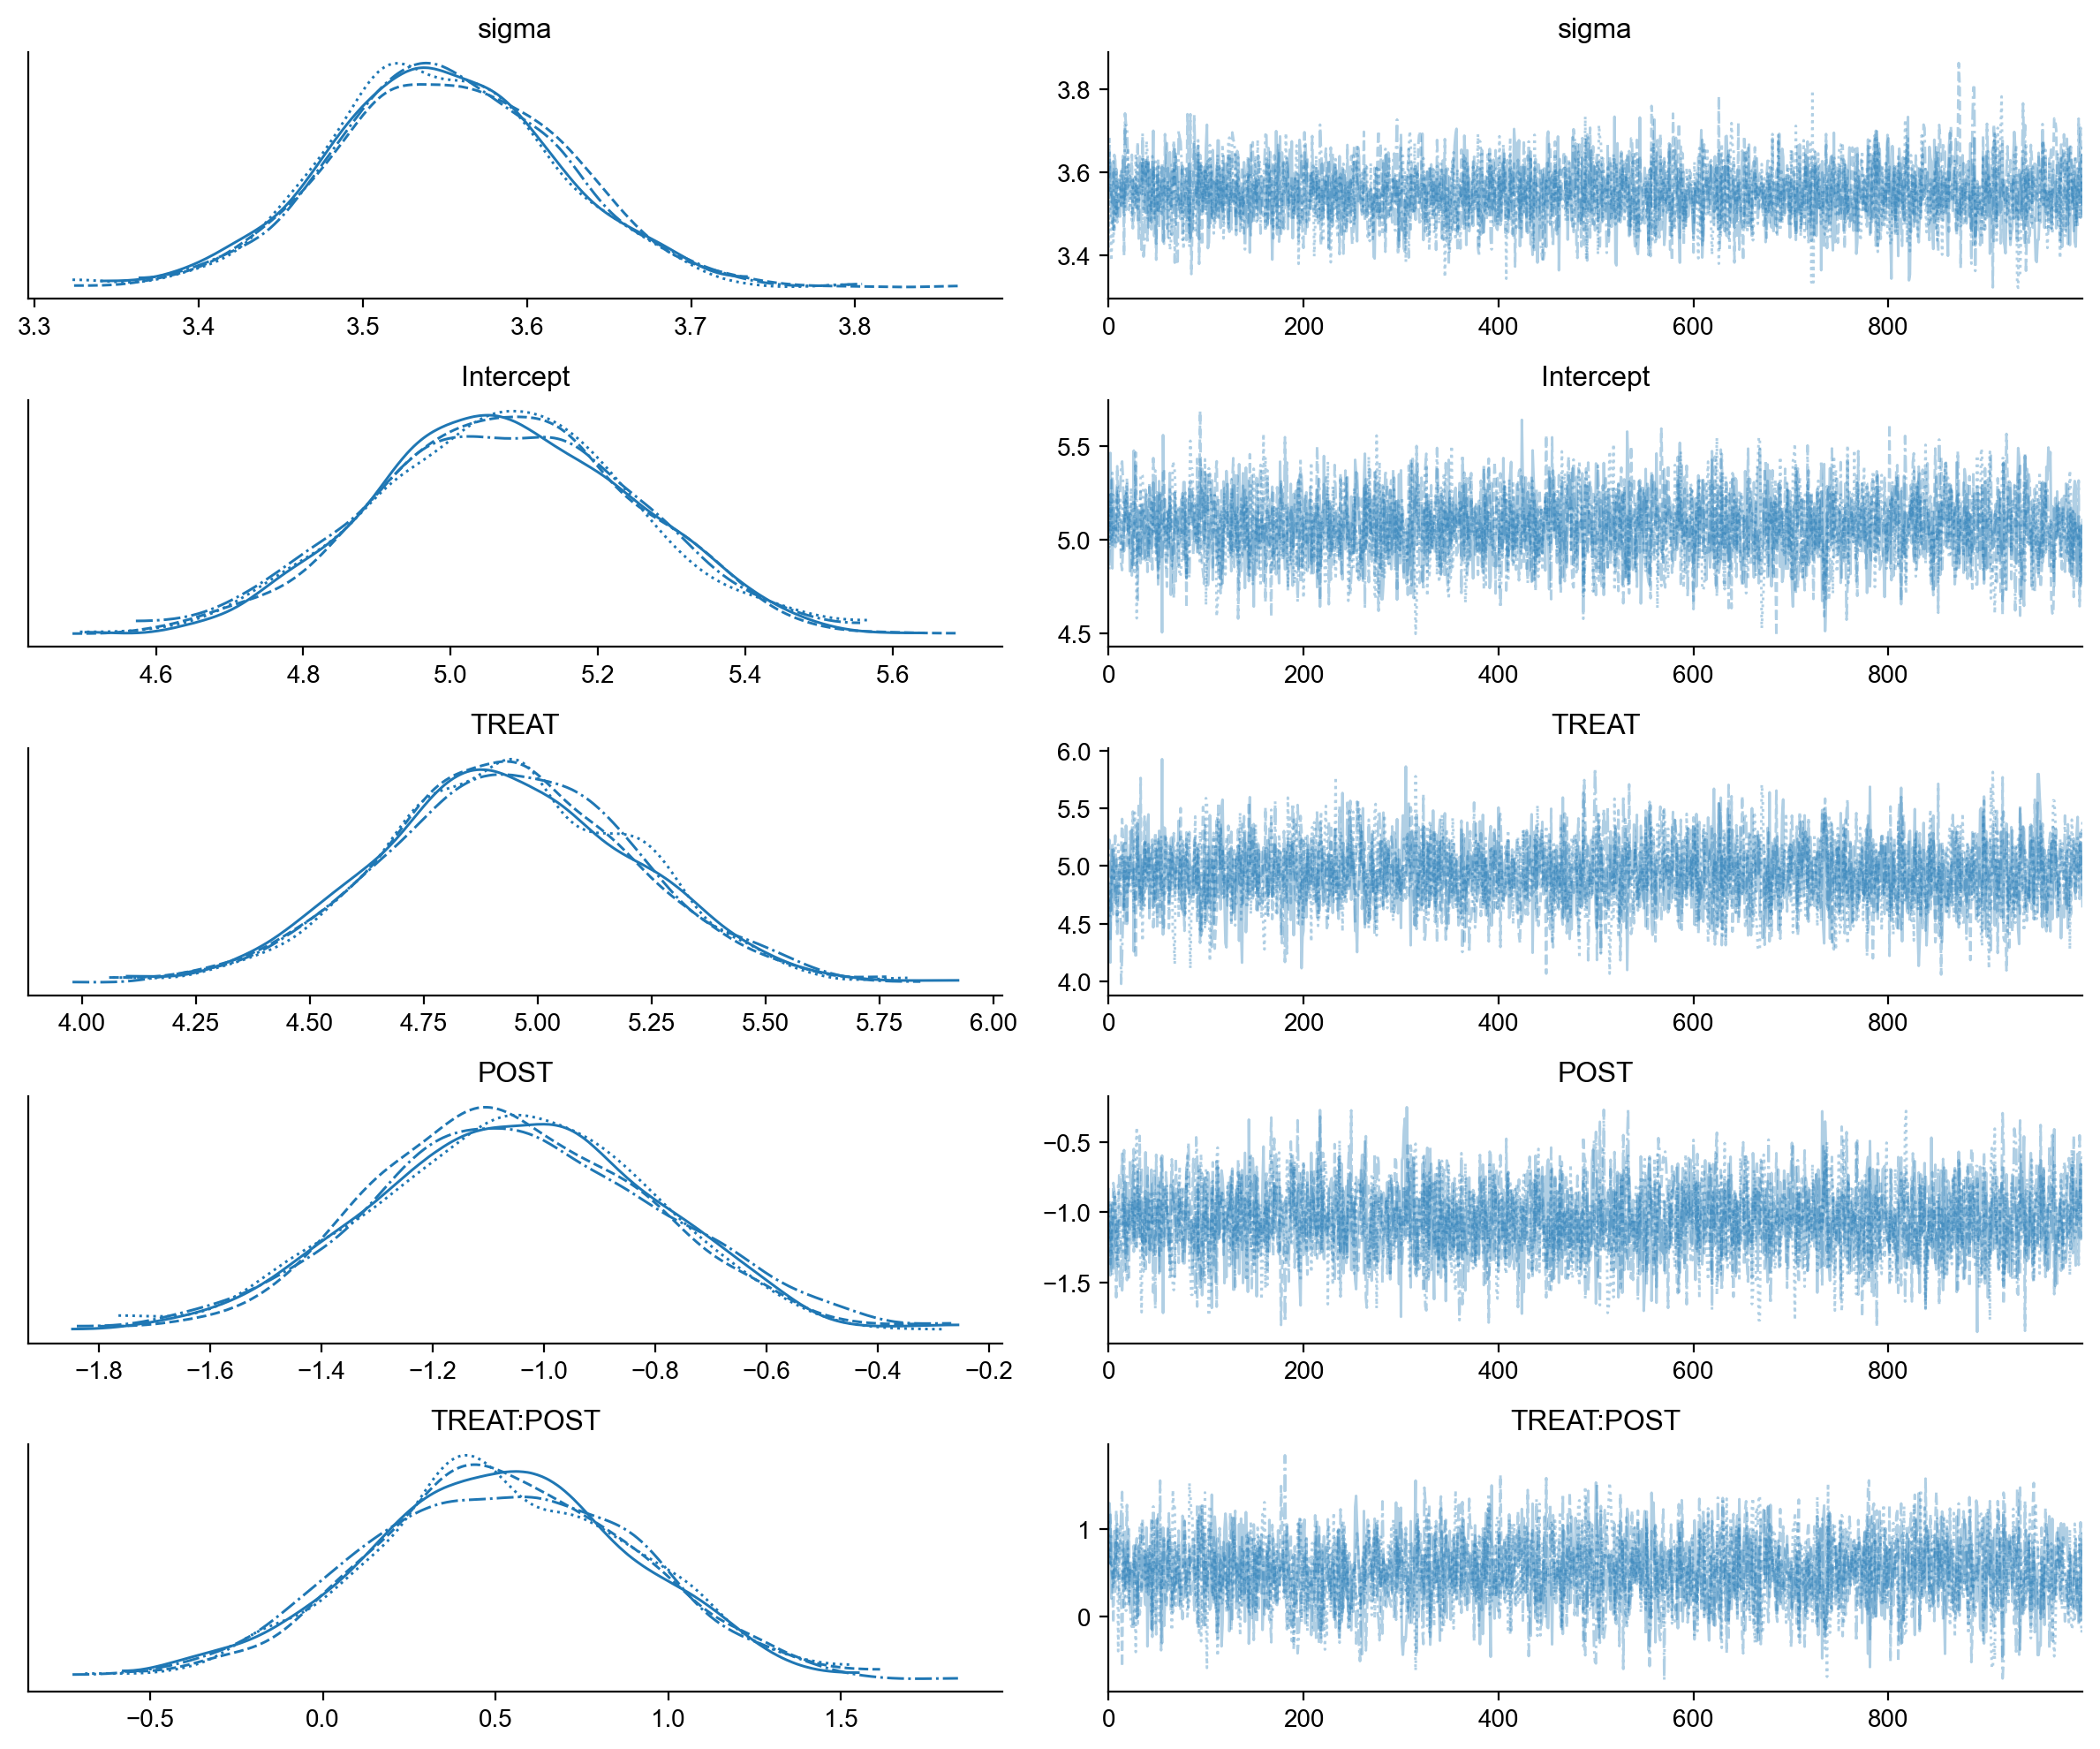

In [7]:
model.plot_trace()
plt.tight_layout()
sns.despine();

In [8]:
model.fitted_model['posterior']['TREAT:POST']

<xarray.DataArray 'TREAT:POST' (chain: 4, draw: 1000)> Size: 32kB
array([[ 0.62148778,  1.29367553,  1.06666727, ..., -0.0114142 ,
        -0.03251931,  0.94383749],
       [ 1.09301771,  0.67054694,  0.6083993 , ...,  0.10894007,
        -0.18609981, -0.10821464],
       [ 0.6797156 ,  1.00445291,  1.16233421, ...,  0.01246383,
         0.65163775,  0.83105762],
       [ 0.65485479,  0.7170835 ,  0.59817091, ...,  1.07583913,
         0.32846897,  0.1637303 ]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

<Figure size 640x480 with 0 Axes>

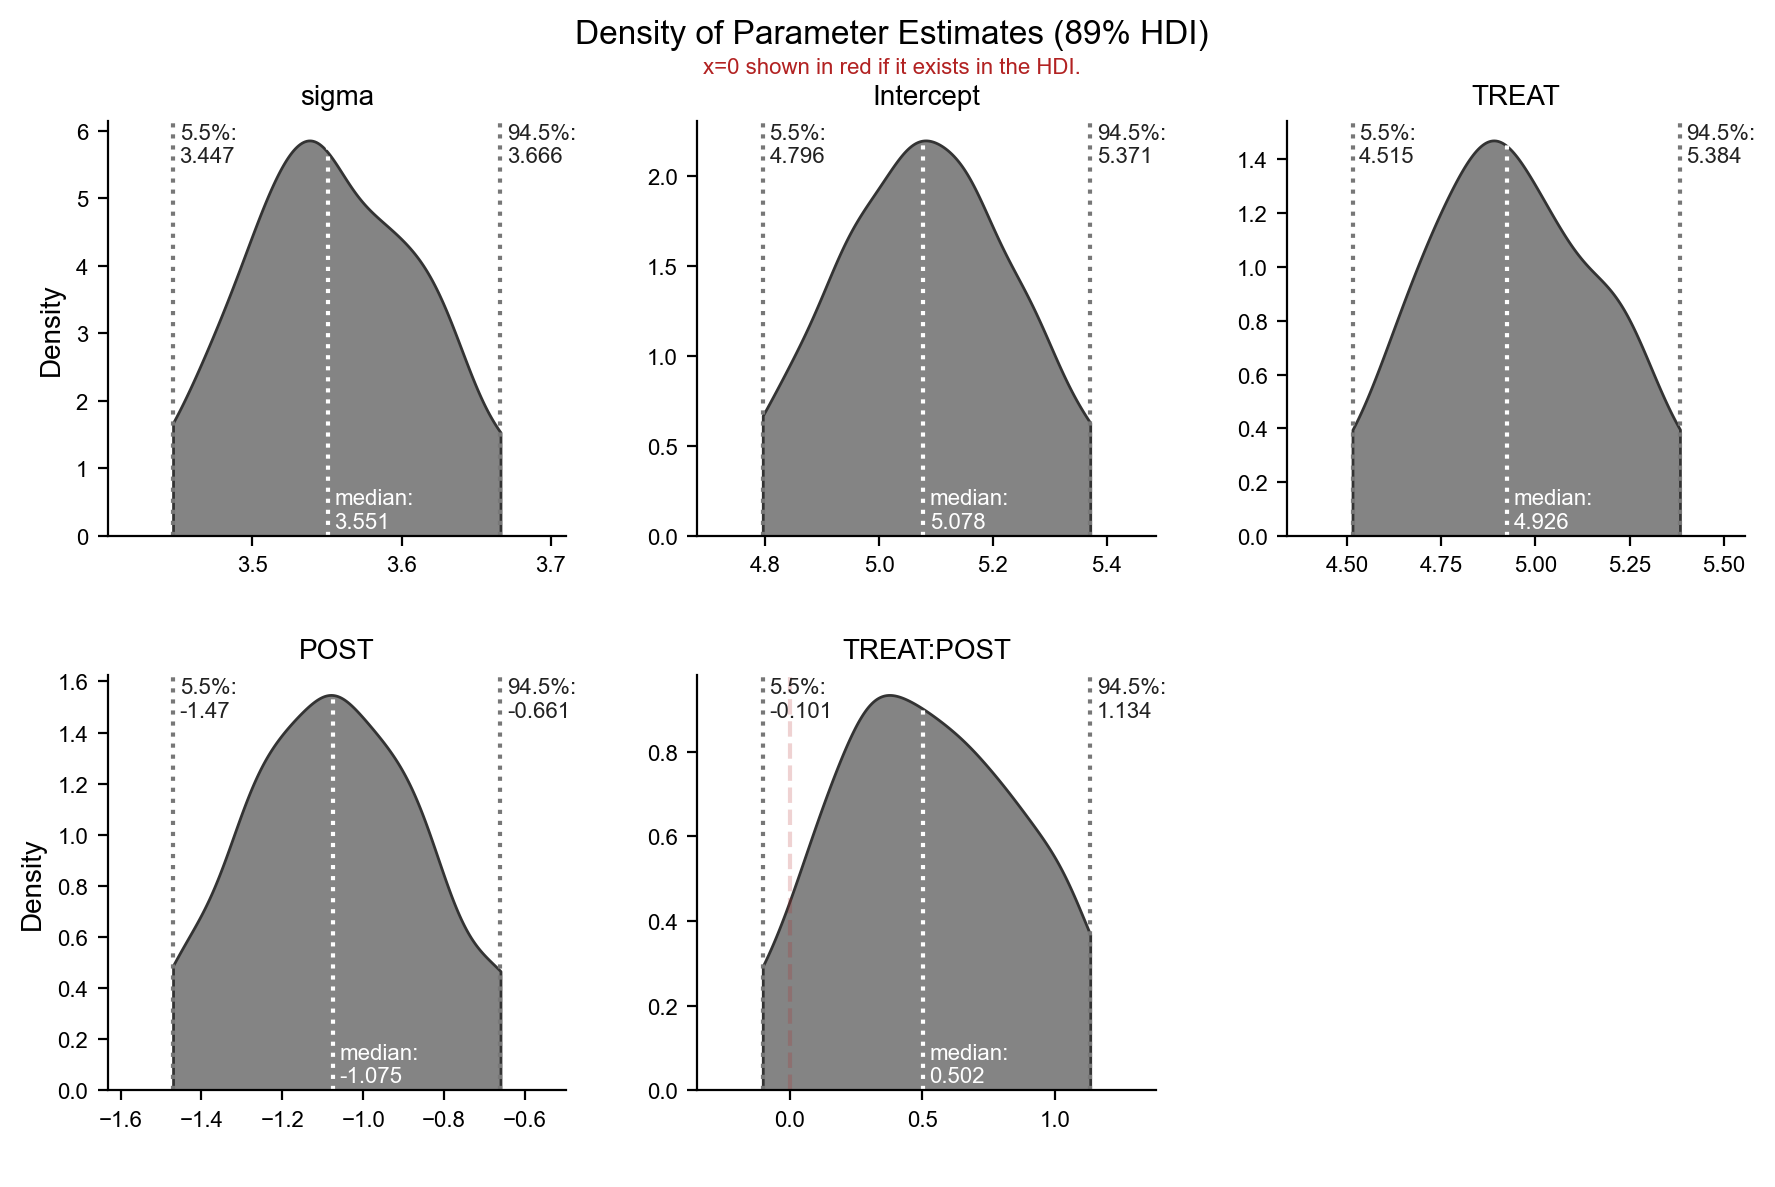

In [9]:
model._plot_hdi_density(interval=0.89)

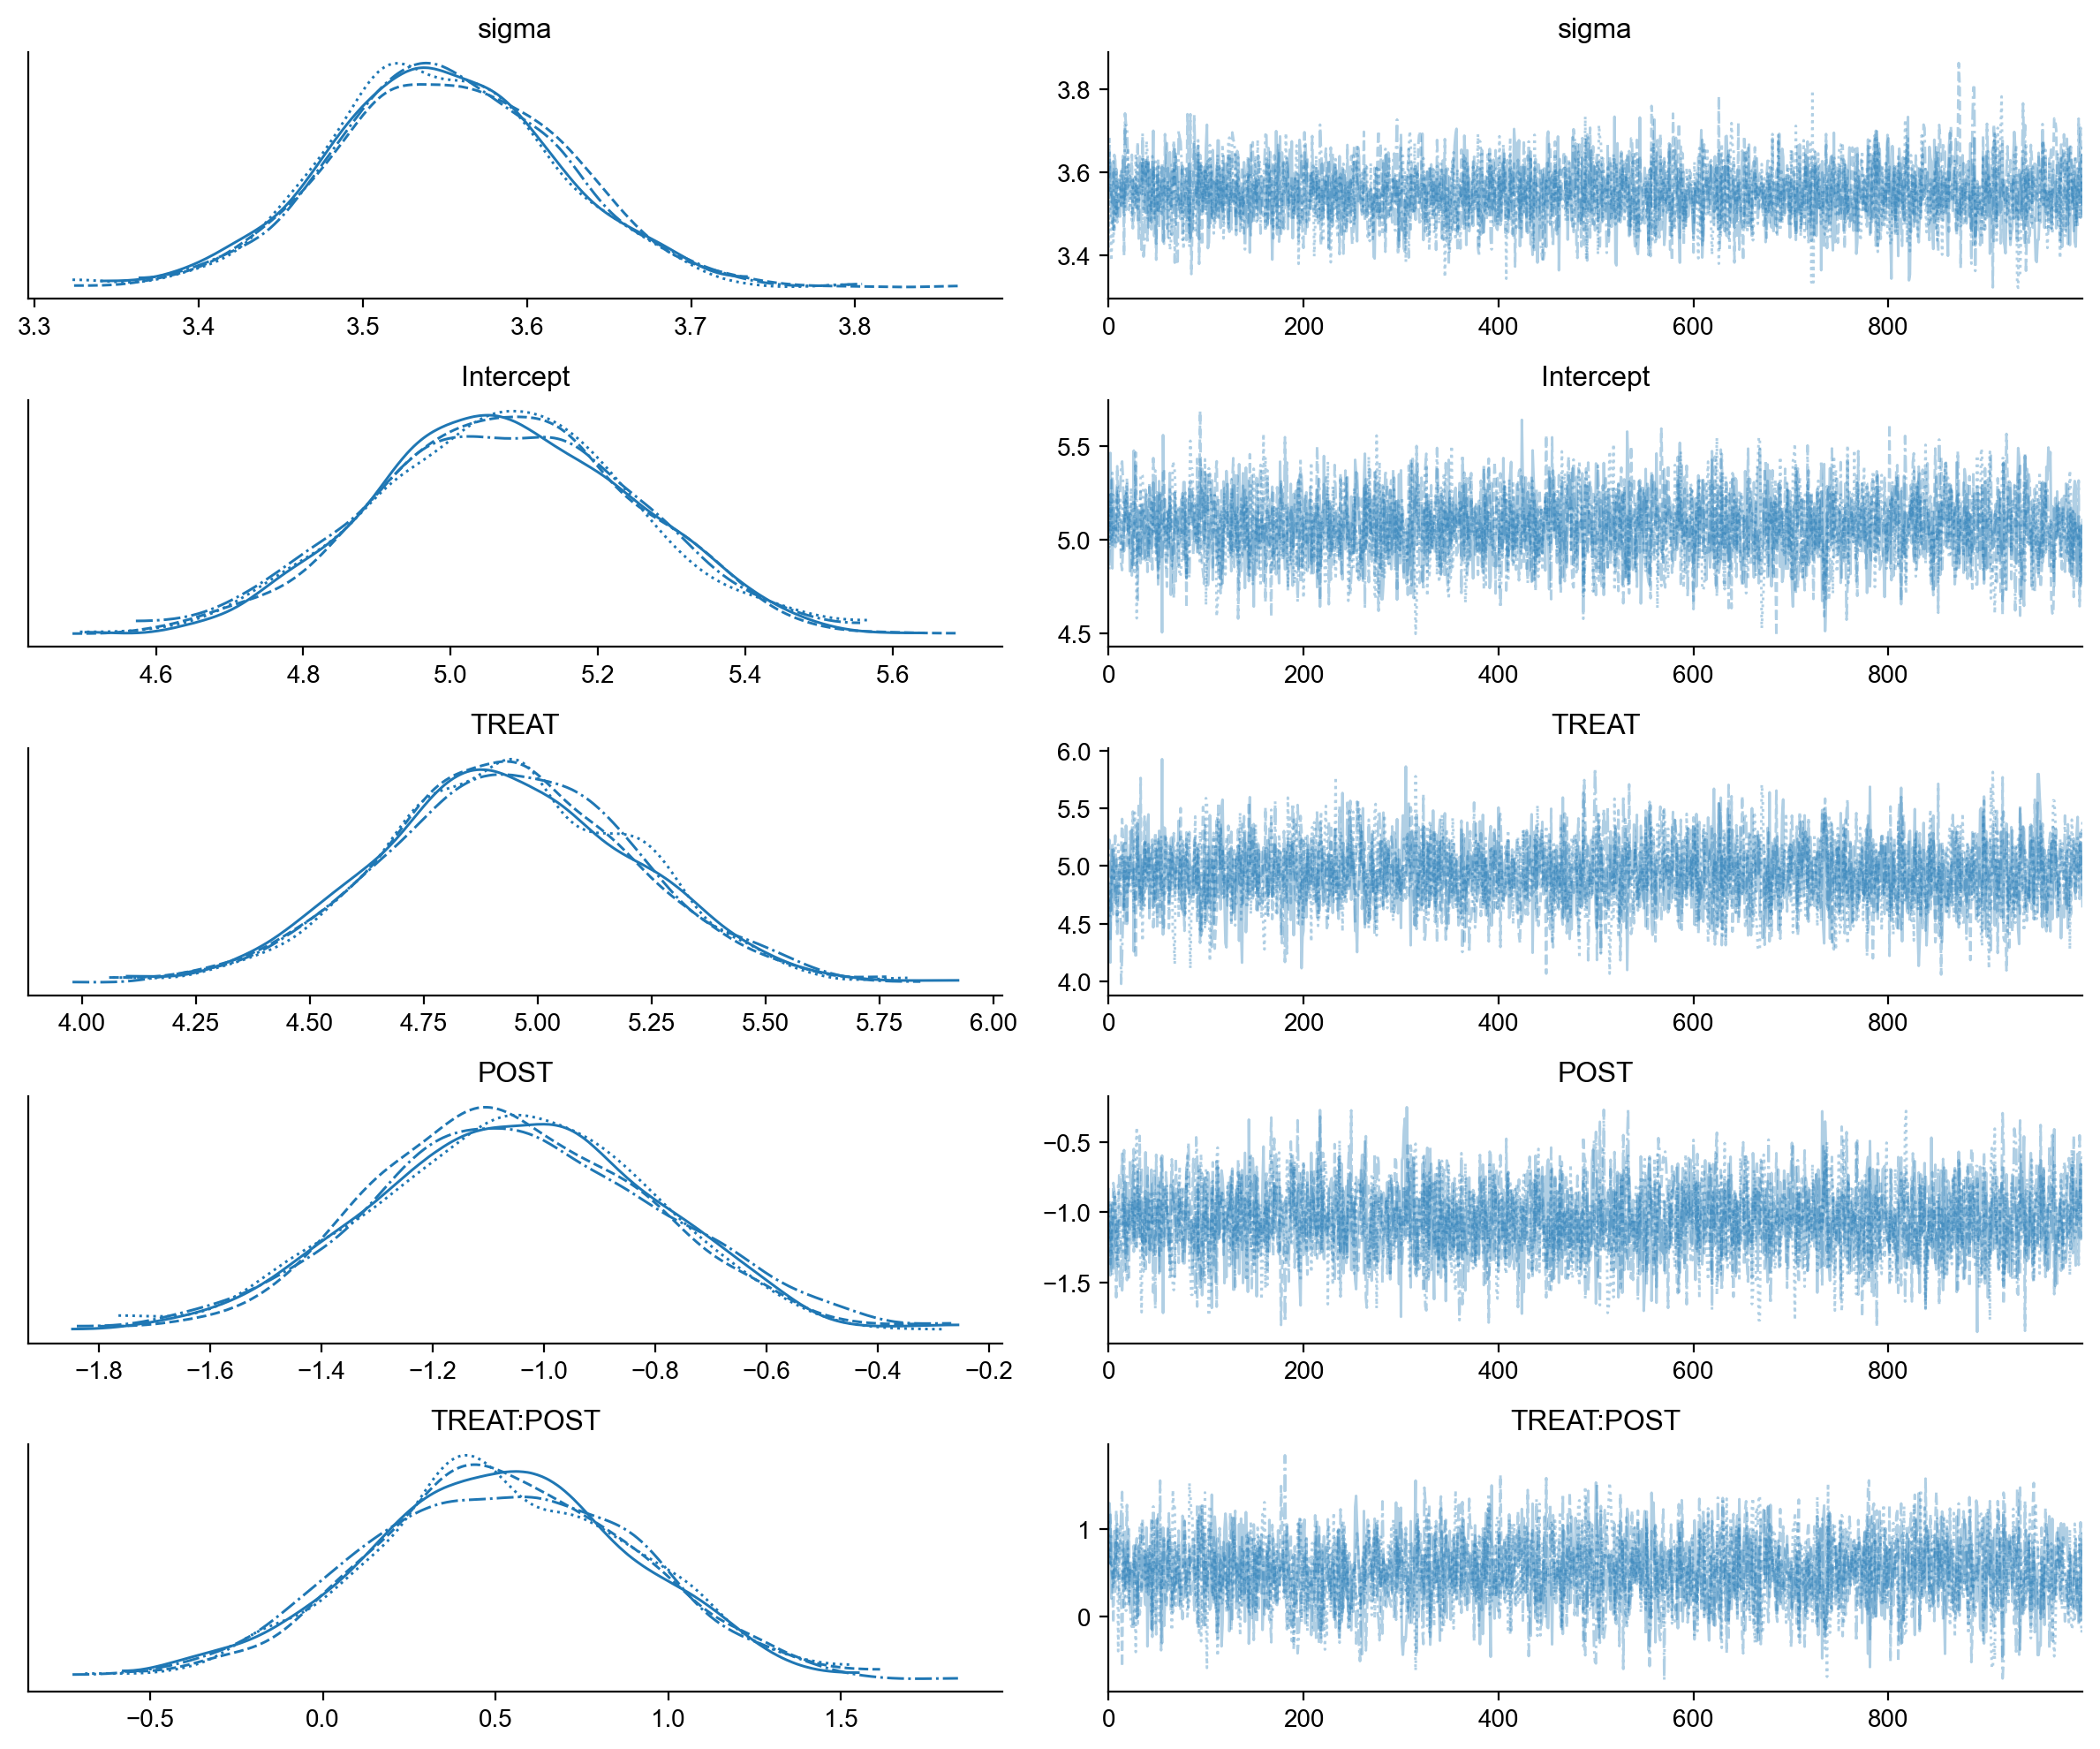

In [10]:
model.plot_trace()

#### Plot effects for DiD regression

First, plot with split point at midline (along x axis).

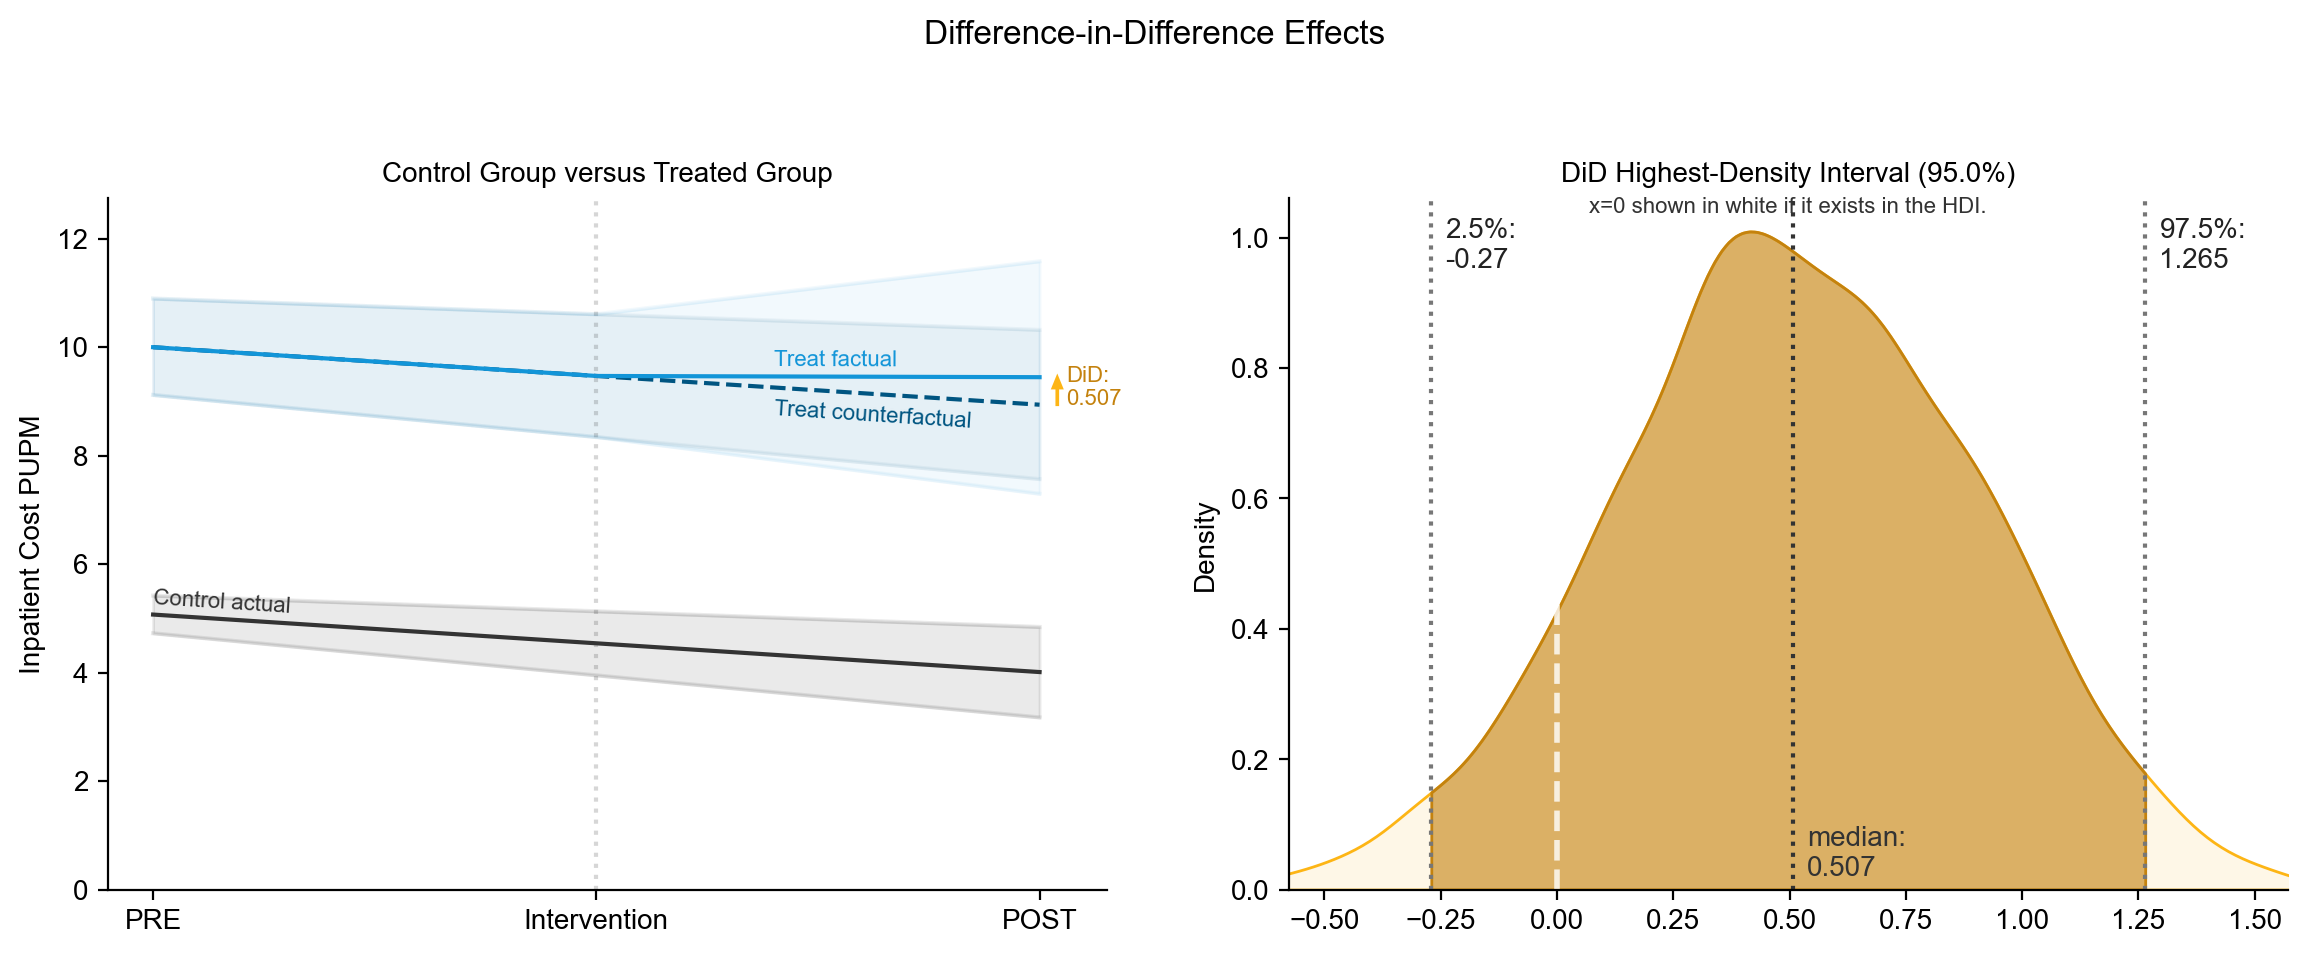

In [11]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.95, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, y_label='Inpatient Cost PUPM', y_pad=(0.2, 0.35, 0.2), labels_above_line=(True, False, True))

Next, plot with no split (more to the point, the split point is at $x=0$).  Also, change the HDI to 89%, and leave out the y_label specification.

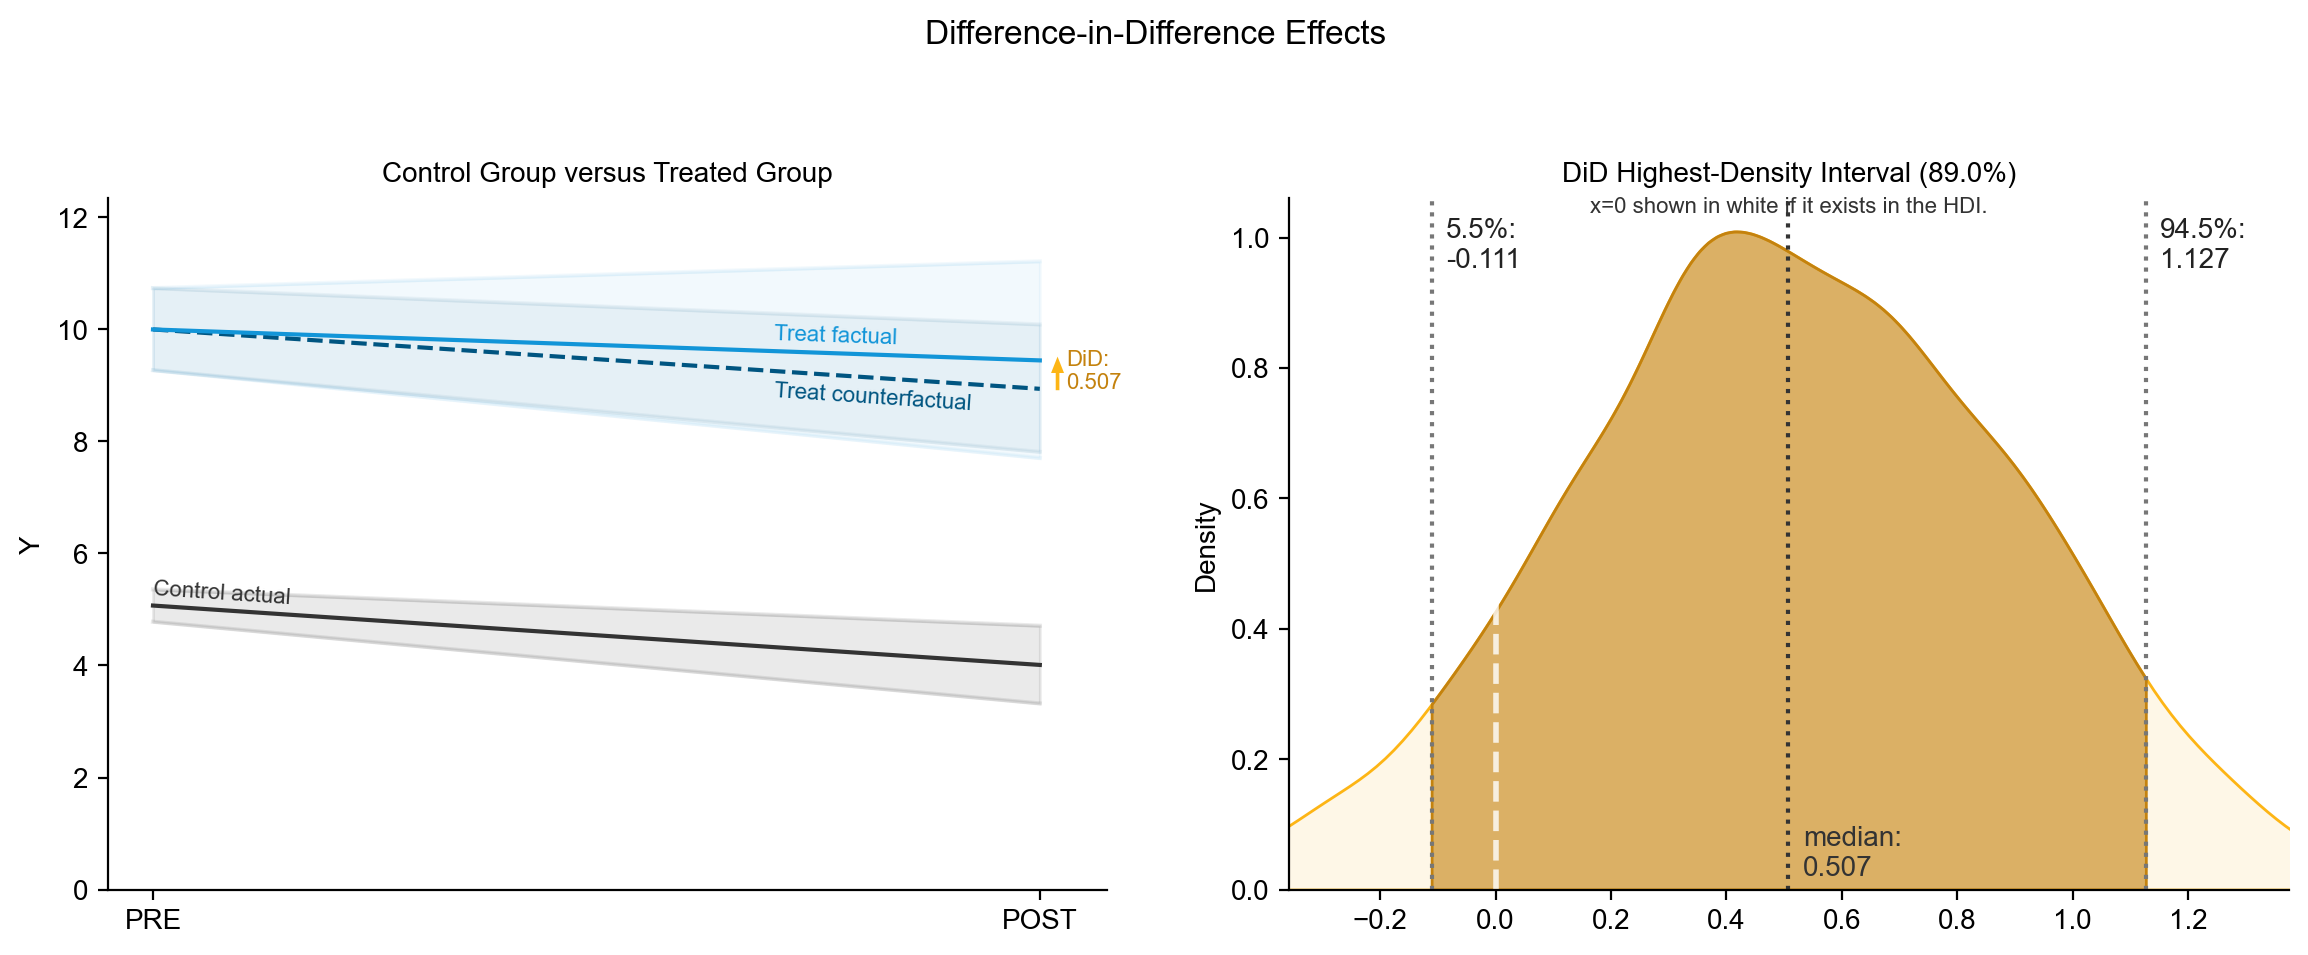

In [12]:
model.plot_effects(model, line_type = 'single', figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_intervals=False, show_did=True, y_pad=(0.2,0.3,0.2), labels_above_line=(True,False,True))

### Run DiD on treat and matched control

In [13]:
model.match_control_nn(match_features=['Female', 'Risk'])

model.fit(reg_formula = 'Y ~ TREAT + POST + TREAT * POST')



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


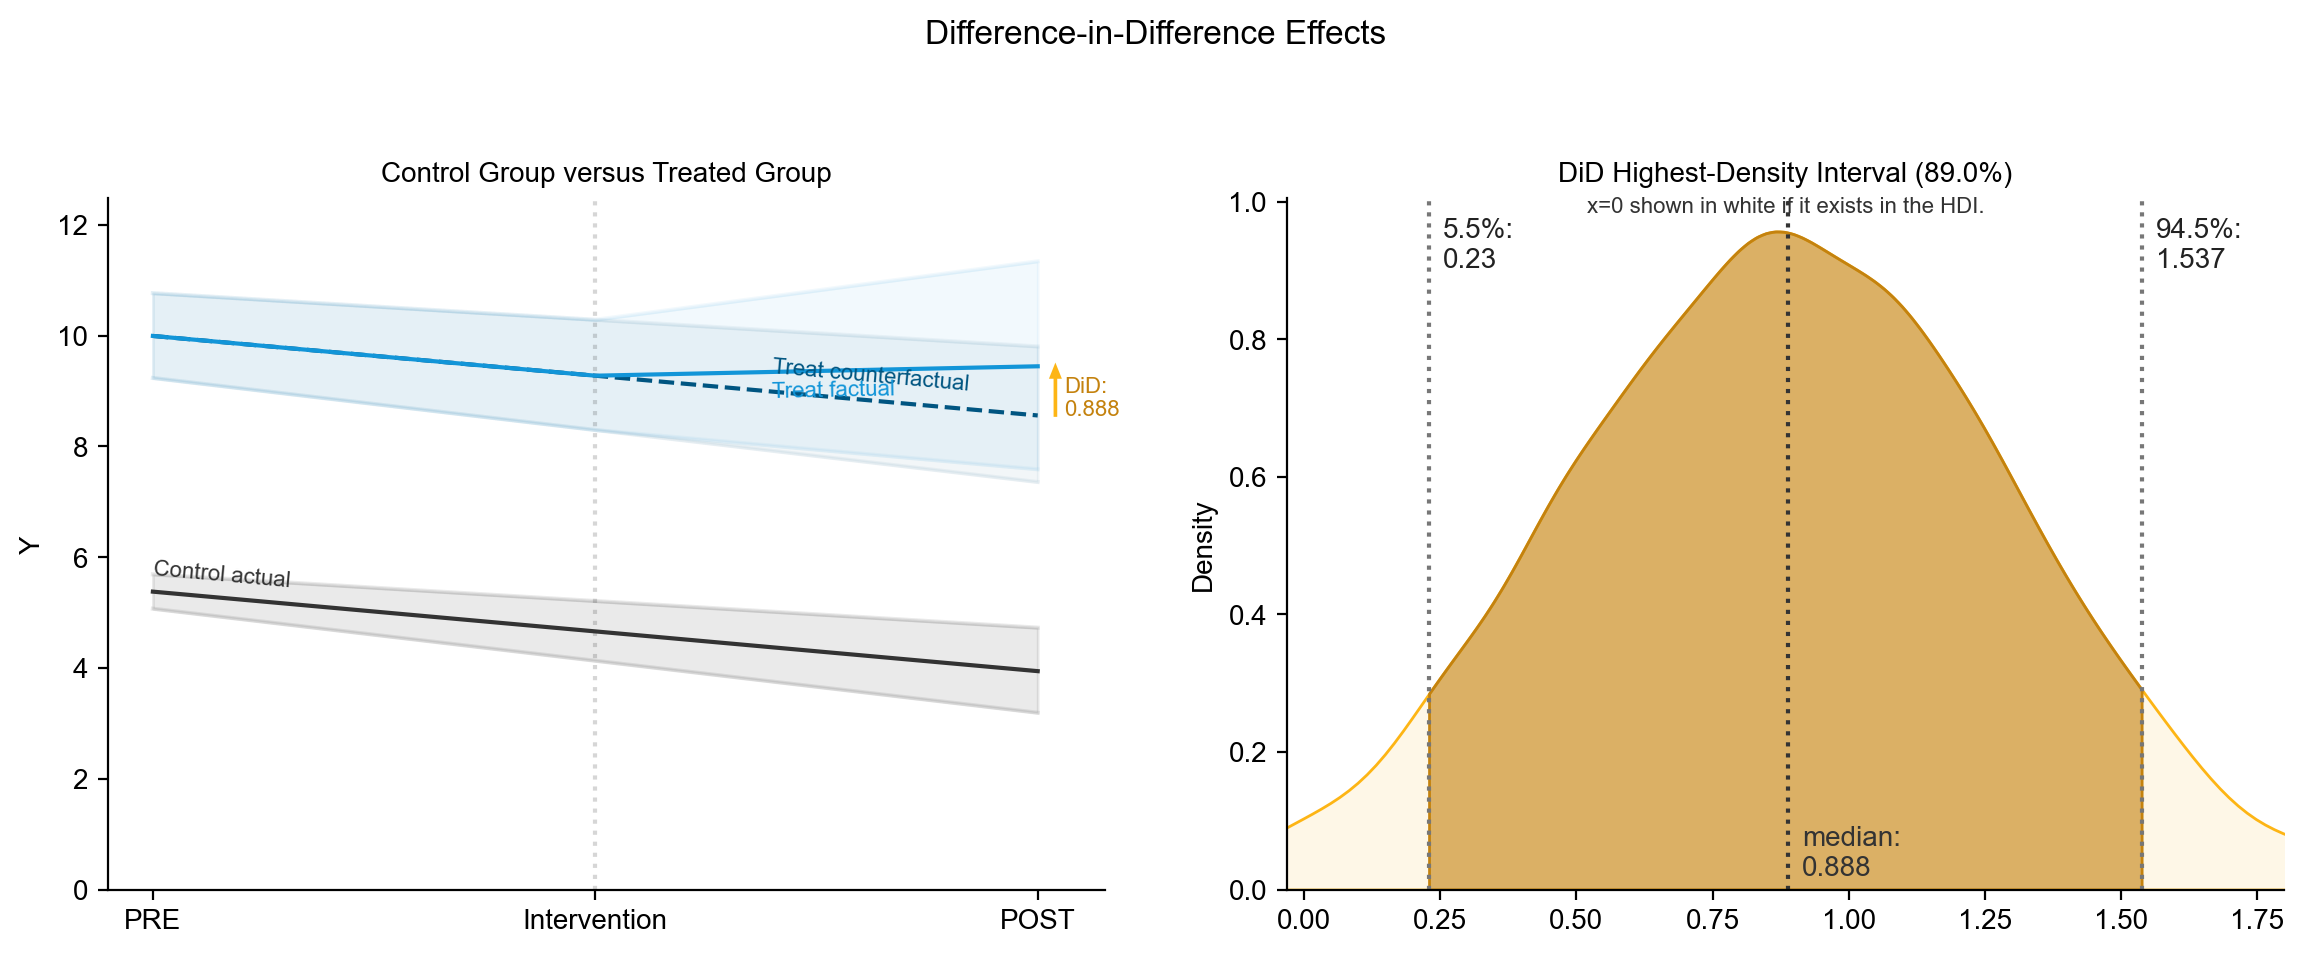

In [14]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, y_pad=(0.3, 0.3, 0.3), labels_above_line=(False, True, True))

In [15]:
model.fit(reg_formula = 'Compliance ~ TREAT + POST + TREAT * POST')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TREAT, POST, TREAT:POST]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


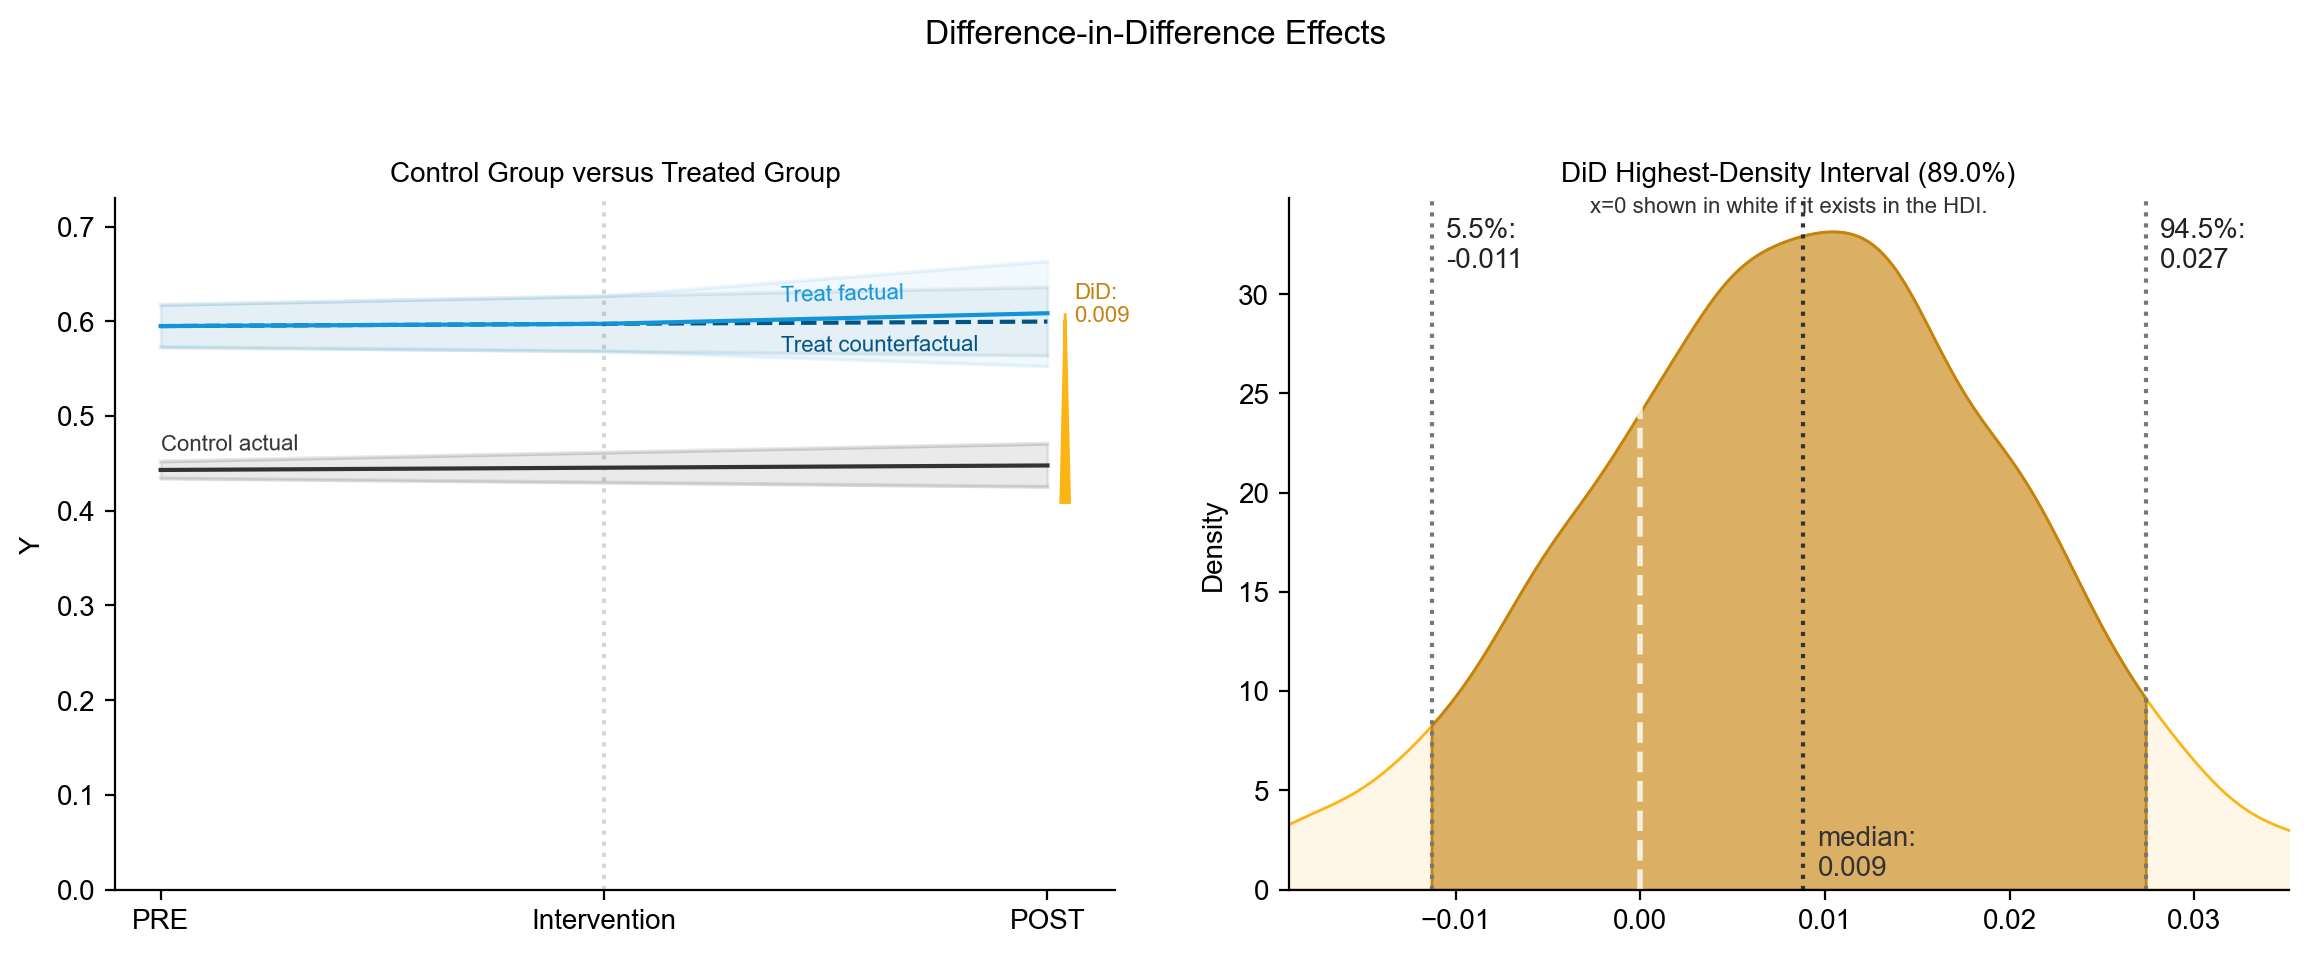

In [16]:
model.plot_effects(model, line_type = 'single', split_point=0.5, figsize=(12,5), hdi=0.89, 
                   suptitle_fontsize=12, title_fontsize=10, label_fontsize=8, tick_fontsize=10, 
                   show_did=True, labels_above_line=(True, False, True))

#### scratch space


In [17]:
# Rename "index" to "observation"
idx_treat = pd.Index.rename(model.data_treat.index, name='observation')
model.data_treat.index = idx_treat

idx_control = pd.Index.rename(model.data_control.index, name='observation')
model.data_control.index = idx_control

idx_matched_control = pd.Index.rename(model.data_matched_control.index, name='observation')
model.data_matched_control.index = idx_matched_control

idx_combined = pd.Index.rename(model.data_combined.index, name='observation')
model.data_combined.index = idx_combined

# Create xarrays
arr_treat   = xr.Dataset.from_dataframe(model.data_treat)
arr_control = xr.Dataset.from_dataframe(model.data_control)
arr_matched_control = xr.Dataset.from_dataframe(model.data_matched_control)
arr_combined = xr.Dataset.from_dataframe(model.data_combined)

# Set attributes
attr_dict = {'bistro_version': __version__,
             'Treat group variable':'TREAT',
             'Post intervention variable':'POST',
             'Outcome variable':'Y'
            }
arr_list = [arr_treat, arr_control, arr_matched_control, arr_combined]

for k,v in attr_dict.items():
    for arr in arr_list:
        arr.attrs[k] = v
    


AttributeError: 'Dataset' object has no attribute 'index'

In [ ]:
if isinstance(arr_control, xr.core.dataset.Dataset):
    print('yup')
else:
    print('nope')

In [ ]:
temp_treat_vars = sorted(list(arr_treat.keys()))
temp_treat_vars.remove('TREAT')
temp_treat_vars

In [ ]:
list(arr_treat.keys())

In [ ]:
model.plot_effects()

#### Match summaries

TODO: we need to use some metadata for TREAT and POST to get the right data for summarization.

In [23]:
def summarize_match():
    tbl_control_pre = model.data_control.loc[model.data_control['POST']==0].groupby('TREAT').mean().T
    tbl_control_pre.columns = 'TREAT'

tbl_control_pre.head()

SyntaxError: expected ':' (1581509513.py, line 1)

In [ ]:
import sys
from IPython.display import HTML, IFrame, display
display(HTML('<h3>Versions used in this notebook</h3>'))
pyver_dict = {}
pyver_dict['python'], pyver_dict['GCC'] = sys.version.split('\n')
modules_dict = {m.__name__: m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
pyver_dict.update(modules_dict)
modules_df = pd.DataFrame(pyver_dict, index=[0]).T
modules_df.columns = ['Version']
modules_df

In [22]:
model.data_match_features

['Female', 'Risk']